## XGBoost Classifier

The first algorithm that we will use is the XGBoost with its random forest classifier. To do that, we must first:

- Normalize the data if necessary
- Divide the data between trainning and testing
- Cross validate the models

This will be done for each one of the designed features.


### Hidden Markov Models

Here we use the model estimated from the Hidden Markov Models library, wich is the estimated $A$ matrix, or the so called transition probability matrices as feature for the learning classifier. For that we must read the pickle file with the desired features:

In [1]:
import pickle 

with open('./hmm_data.pkl', 'rb') as file:
    data = pickle.load(file)
data.keys()

dict_keys(['y', 't', 'labels', 'features'])

#### Manipulate features

Here we organize the features into table structures to be more easy to deal on the learning algorithm.

In [2]:
import numpy as np
from sklearn import preprocessing

# Encode the label
le_hmm = preprocessing.LabelEncoder()
le_hmm.fit( data['labels'] )

# Define the model order
feat = data['features']
nx = feat['prob_matrix'][0].shape[0]

regressors = []
for phi in feat['prob_matrix']:
    # Reshape the regressor
    reg = phi.reshape(nx*nx)
    # Add to the regressors
    regressors.append(reg)   
# Normalize the regressors
regressors = preprocessing.normalize(regressors)
# Define outputs as encoded variables
outputs = le_hmm.transform(data['labels'])

#### Train-Test Split

Segregate the data in train and test groups...

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( 
    regressors, outputs, test_size=0.33, random_state=42)

#### Train model



In [4]:
import xgboost as xgb

param_dist = {
    'objective':'binary:logistic', 
    'n_estimators':5
}

clf = xgb.XGBClassifier(**param_dist)

clf.fit(X_train, y_train,
        eval_set=[
            (X_train, y_train), 
            (X_test, y_test)
        ],
        eval_metric='logloss',
        verbose=True)

[0]	validation_0-logloss:0.55354	validation_1-logloss:0.66658
[1]	validation_0-logloss:0.48433	validation_1-logloss:0.66545
[2]	validation_0-logloss:0.41414	validation_1-logloss:0.66836
[3]	validation_0-logloss:0.36141	validation_1-logloss:0.68176
[4]	validation_0-logloss:0.32212	validation_1-logloss:0.73011


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

#### Hyper tunning

We could consider tunning the model hyper parameters to answer questions such as:

- Wich value of `n_estimators` is the best for this model and data?
- Wich cost function is the best to be selected as `objective` for this model?

We could do a hyper search, to find the best hyper parameters for this model, automating the hyper parameter selection. There are several already builded algorithms to optimize this parameter search, and build find with high performance the best parameters, provided a set of possible values. But, to understand what those algorithms actually does, we could once build our own search algorithm...

As an example, lets run a first handly defined hyper parameter tunning using the confusion matrix of the model:

In [5]:
from sklearn.metrics import confusion_matrix

n_estimators = [ k+1 for k in range(100)]

conf_matrices = []
for opt in n_estimators:
    # Update the model parameters
    param_dist['n_estimators'] = opt
    # Create the xgBoost classifier
    clfs = xgb.XGBClassifier(**param_dist)
    # Fit the model to the data
    clfs.fit(X_train, y_train,
            eval_metric='logloss',
            verbose=True)
    # Estimate the test output
    y_pred = clfs.predict(X_test)
    # Compute the confusion matrix
    conf_mat = confusion_matrix(
        y_test, y_pred,
        normalize='true')
    # Save the confusion matrix
    conf_matrices.append(conf_mat)

In [6]:
from utils import *

# Create and organize the plot values
plot_vals = {
    'true': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    },
    'false': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    }
}
for result in conf_matrices:
    plot_vals['true']['confirmed targets'].append(result[0,0])
    plot_vals['true']['eclipsing binaries'].append(result[1,1])
    plot_vals['false']['confirmed targets'].append(result[0,1])
    plot_vals['false']['eclipsing binaries'].append(result[1,0])

x_values = range(len(conf_matrices))
x_data = [x_values, x_values, x_values, x_values]
y_data = [plot_vals['true']['confirmed targets'],
          plot_vals['true']['eclipsing binaries'],
          plot_vals['false']['confirmed targets'],
          plot_vals['false']['eclipsing binaries']]
legends= ['True - C.T.', 'True - E.B.', 'False - C.T.', 'False - E.B.']
colors = [6, 7, 2, 3]

p = visual.multline_plot(x_data, y_data,
                         legend_label=legends, 
                         title='Hyper parameter search - Confusion plot',
                         color_index=colors,
                         y_axis={'label': 'Intensity'},
                         x_axis={'label': 'n_estimators'})
visual.show_plot(p)

Loading BokehJS ...

The user might see that the best values for the `n_estimators` parameter is something close to `[4,5,6]`. When we have a range of values, such as here, usually is advisable to use the simpler model, in this case `n_estimators=4`, wich is the value defined before.

> *Notice that the value `n_estimators`$=n_x$ defined in the previous step algorithm. Since the hidden markov model is pretty simple such as the classifier. Therefore is possible that the hidden markov model is underfitted, this means that the markov model is to simple to represent the information from the ligt curve, since there is no redundancy on the model. This is infered by checking that `n_estimators`$=n_x$ is the best solution for this problem.*

Considering more complex hidden markov models, such as one with $n_x \in \{8,12,16,20\}$, we can get to some other models, as it follows:

#### Results

Here we include some visualization results for the xgBoost algorithm classification. As the first result, we just print the model eval metrics, here the *log loss* of the model, for both the trainning and testing data.

In [7]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

evals_result = clf.evals_result()
pp.pprint(evals_result)

{ 'validation_0': { 'logloss': [ 0.553543,
                                 0.48433,
                                 0.414144,
                                 0.361407,
                                 0.322122]},
  'validation_1': { 'logloss': [ 0.666577,
                                 0.665451,
                                 0.668356,
                                 0.681761,
                                 0.730108]}}


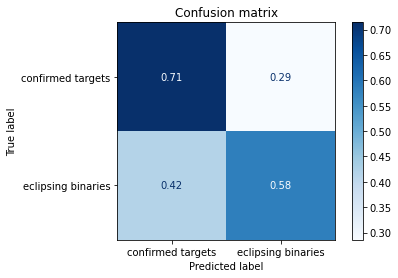

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=le_hmm.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Confusion matrix')
plt.show()

In [ ]:
import pickle 

with open('./freq_Data.pkl', 'rb') as file:
    data = pickle.load(file)


In [ ]:

feat_1 = data['features']['freq']
feat_2 = data['features']['spec']

fmax, fmin, size = [], [], []
for feat in feat_1:
    fmax.append(feat.max())
    fmin.append(feat.min())
    size.append(len(feat))

In [ ]:
import matplotlib.pyplot as plt


plt.figure()
for s, f in zip(feat_2, feat_1):
    plt.plot(f, s)
plt.plot([max(fmax), max(fmax)],[0, 3*10**7])
plt.xscale("log")
plt.show()

In [ ]:
max(fmax), min(fmax)